# Predição de dose semanal para regulação de INR no uso da Vafarina

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import time
import joblib
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping
from sklearn.ensemble import RandomForestClassifier
from models.data_manipulator import INRDataManipulation

## 1. Importação e tratamento dos dados

In [5]:
path = r"G:\.shortcut-targets-by-id\1pVv4_awj3MCrGLaPaYx5OLlzmRd51R8S\GemeosDigitais_Saude\Planilhas HNE\ALINE GOMES DE FREITAS RICARDO.xlsx"

data = pd.read_excel(path, sheet_name="TTR")
display(data)

,DOSE SEMANAL,Test Date,INR,Days Since Last Test,INR Diff,Previous INR Within Range?,Current INR Within Range?,Scenario,INR Diff Above Range,INR Diff Within Range,INR Diff Below Range,Days within Range since Last Test,% Days within Range since Last Test,Unnamed: 13,Unnamed: 14,Unnamed: 15
0,95.0,2022-08-16,2.75,NaN,,NaN,In Range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Low Range,2.500000
1,95.0,2022-08-23,2.09,7.0,-0.66,In Range,Below,Calculate,0.00,0.25,0.41,2.651515,0.378788,NaN,High Range,3.500000
2,95.0,2022-08-26,2.96,3.0,0.87,Below,In Range,Calculate,0.00,0.46,0.41,1.586207,0.528736,NaN,NaN,NaN
3,95.0,2022-09-20,2.42,25.0,-0.54,In Range,Below,Calculate,0.00,0.46,0.08,21.296296,0.851852,NaN,Rosendaal Method,NaN
4,95.0,2022-10-04,2.02,14.0,-0.4,Below,Below,Below,0.00,0.00,0.40,0.000000,0.000000,NaN,Days Within Range,673.875350
5,100.0,2022-10-18,2.43,14.0,0.41,Below,Below,Below,0.00,0.00,0.41,0.000000,0.000000,NaN,Total Days,812.000000
6,100.0,2022-10-25,2.61,7.0,0.18,Below,In Range,Calculate,0.00,0.11,0.07,4.277778,0.611111,NaN,% Days Within Range,0.829896
7,100.0,2022-11-08,2.67,14.0,0.06,In Range,In Range,In Range,0.00,0.06,0.00,14.000000,1.000000,NaN,NaN,NaN
8,100.0,2022-12-13,3.29,35.0,0.62,In Range,In Range,In Range,0.00,0.62,0.00,35.000000,1.000000,NaN,% in Range,NaN
9,100.0,2022-12-20,2.64,7.0,-0.65,In Range,In Range,In Range,0.00,0.65,0.00,7.000000,1.000000,NaN,Total Number of Tests,25.000000


In [6]:
# Criando colunas de low_range e high_range
data['low_range'] = data.loc[0]['Unnamed: 15']
data['high_range'] = data.loc[1]['Unnamed: 15']

# Ajustando nomes e filtrando colunas
data_filtred = data[['DOSE SEMANAL', 'Test Date', 'INR', 'INR Diff', 'low_range', 'high_range']].copy()
data_filtred = data_filtred.rename(columns={'DOSE SEMANAL': 'dose_semanal', 'INR Diff': 'inr_diff', 'INR': 'inr', 'Test Date': 'test_date'})

# Ajuste de Dtype
data_filtred["inr_diff"] = pd.to_numeric(data_filtred["inr_diff"], errors="coerce")

# Inserindo valores para completar a tabela
media_inr = data_filtred["inr"].mean()      
data_filtred["inr"] = data_filtred["inr"].fillna(media_inr)

data_filtred['inr_diff'] = data_filtred['inr'].diff().round(2)
data_filtred.loc[0, 'inr_diff'] = 0.00


display(data_filtred)
print(data_filtred.info())

,dose_semanal,test_date,inr,inr_diff,low_range,high_range
0,95.0,2022-08-16,2.750,0.00,2.5,3.5
1,95.0,2022-08-23,2.090,-0.66,2.5,3.5
2,95.0,2022-08-26,2.960,0.87,2.5,3.5
3,95.0,2022-09-20,2.420,-0.54,2.5,3.5
4,95.0,2022-10-04,2.020,-0.40,2.5,3.5
5,100.0,2022-10-18,2.430,0.41,2.5,3.5
6,100.0,2022-10-25,2.610,0.18,2.5,3.5
7,100.0,2022-11-08,2.670,0.06,2.5,3.5
8,100.0,2022-12-13,3.290,0.62,2.5,3.5
9,100.0,2022-12-20,2.640,-0.65,2.5,3.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dose_semanal  29 non-null     float64       
 1   test_date     29 non-null     datetime64[ns]
 2   inr           29 non-null     float64       
 3   inr_diff      29 non-null     float64       
 4   low_range     29 non-null     float64       
 5   high_range    29 non-null     float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 1.5 KB
None


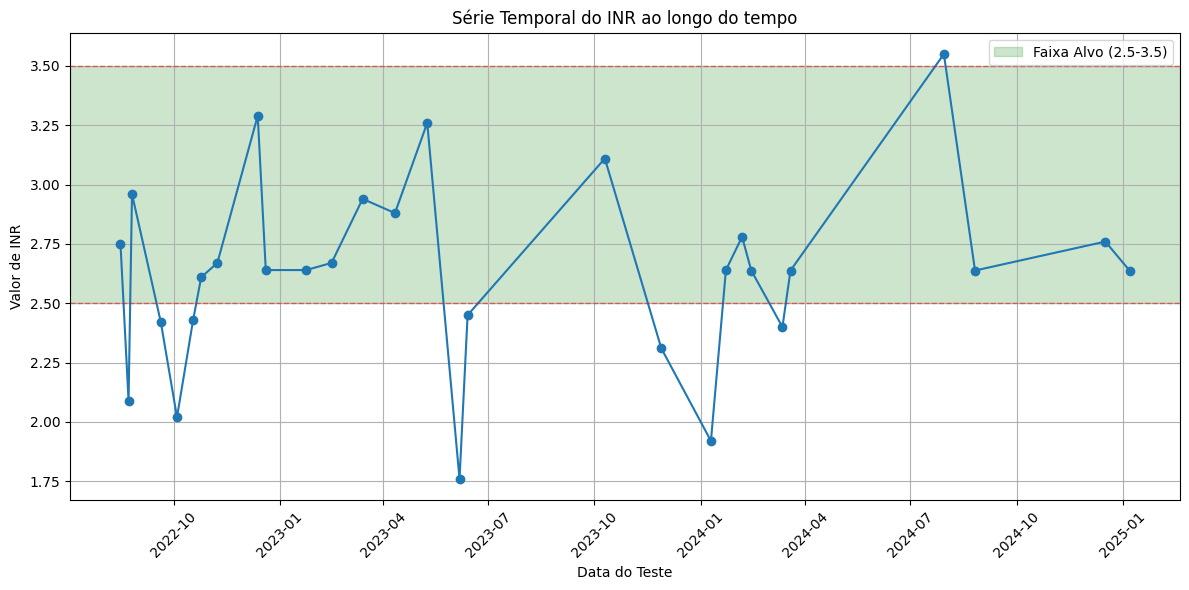

In [7]:
plt.figure(figsize=(12,6))
plt.plot(data_filtred['test_date'], data_filtred['inr'], marker='o')

plt.axhspan(2.5, 3.5, alpha=0.2, color='green', label='Faixa Alvo (2.5-3.5)')
plt.axhline(y=2.5, color='red', linestyle='--', alpha=0.5, linewidth=1)
plt.axhline(y=3.5, color='red', linestyle='--', alpha=0.5, linewidth=1)

plt.xlabel("Data do Teste")
plt.ylabel("Valor de INR")
plt.title("Série Temporal do INR ao longo do tempo")
plt.grid(True)

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [8]:
manipulator = INRDataManipulation(path=path)
data = manipulator.get_data()
display(data)

,test_date,dose_semanal,inr,inr_diff,low_range,high_range,generated
0,2022-08-16,95.0,2.750,0.000,2.5,3.5,False
1,2022-08-23,95.0,2.090,-0.660,2.5,3.5,False
2,2022-08-30,95.0,2.874,0.784,2.5,3.5,True
3,2022-09-06,95.0,2.722,-0.151,2.5,3.5,True
4,2022-09-13,95.0,2.571,-0.151,2.5,3.5,True
...,...,...,...,...,...,...,...
121,2024-12-10,100.0,2.752,0.008,2.5,3.5,True
122,2024-12-17,100.0,2.760,0.008,2.5,3.5,False
123,2024-12-24,100.0,2.719,-0.041,2.5,3.5,True
124,2024-12-31,100.0,2.679,-0.041,2.5,3.5,True


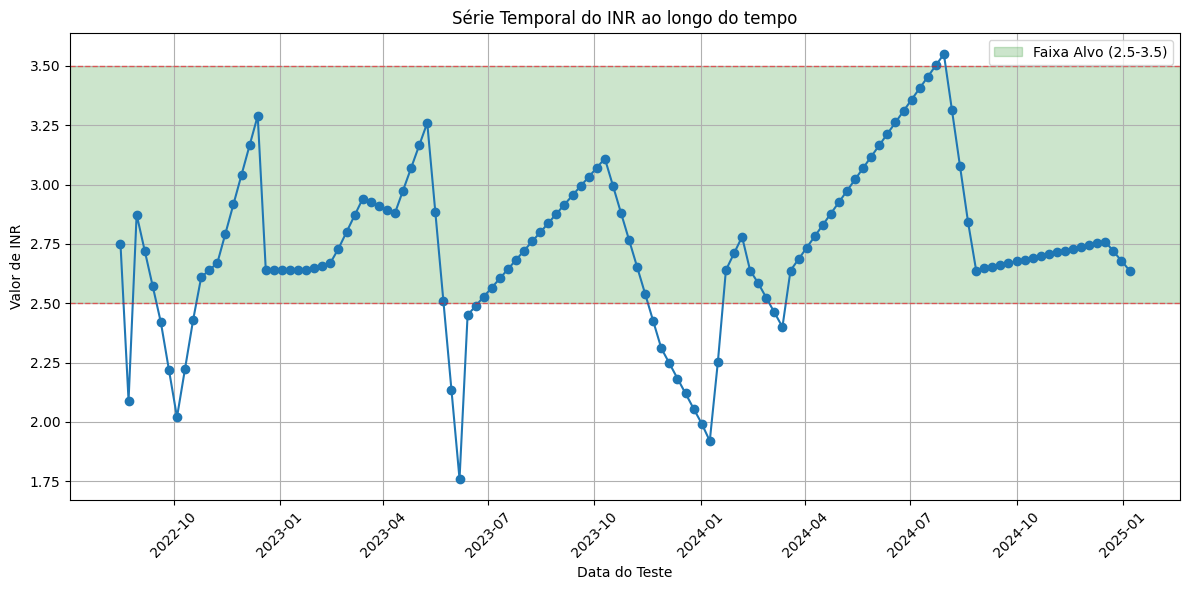

In [9]:
manipulator.plot_inr()

## 2. Treinando XGBoost

In [10]:
#data_xgb = data.copy()   

TARGET_COL = "inr"
DATE_COL = "test_date"
LAGS = [1,2,3,4]              # lags semanais a criar (ajuste conforme necessário)
ROLL_WINDOWS = [3,4]          # janelas para médias móveis
TEST_SIZE_WEEKS = 0.2         # fração do conjunto final para teste (temporal)
RANDOM_STATE = 42

# XGBoost params (valores iniciais; ajuste/tuning depois)
XGB_PARAMS = {
    "n_estimators": 200,
    "max_depth": 4,
    "learning_rate": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": RANDOM_STATE,
    "verbosity": 0
}

In [11]:
df = data.copy()

# features temporais
df['weekofyear'] = df[DATE_COL].dt.isocalendar().week.astype(int)
df['month'] = df[DATE_COL].dt.month.astype(int)
df['year'] = df[DATE_COL].dt.year.astype(int)
df['dayofweek'] = df[DATE_COL].dt.weekday.astype(int)

# lags do INR (cria NaNs no começo)
for lag in LAGS:
    df[f'inr_lag_{lag}'] = df[TARGET_COL].shift(lag)

# médias móveis (rolling) sobre INR
for w in ROLL_WINDOWS:
    df[f'inr_roll_mean_{w}'] = df[TARGET_COL].shift(1).rolling(window=w, min_periods=1).mean()

# manter dose, inr_diff, generated (convertendo booleano)
if 'generated' in df.columns:
    df['generated_flag'] = df['generated'].astype(int)
else:
    df['generated_flag'] = 0

# alvo (já tem) e remover linhas com NaN nas lags
df_features = df.copy()
# Remover linhas iniciais sem lags suficientes
min_lag = max(LAGS) if len(LAGS)>0 else 0
df_features = df_features.iloc[min_lag:].reset_index(drop=True)

# escolher colunas de entrada
feature_cols = ['dose_semanal', 'inr_diff', 'generated_flag',
                'weekofyear','month','dayofweek']

# acrescentar lags e rolling
feature_cols += [f'inr_lag_{lag}' for lag in LAGS]
feature_cols += [f'inr_roll_mean_{w}' for w in ROLL_WINDOWS]

# se alguma feature não existir, ignore
feature_cols = [c for c in feature_cols if c in df_features.columns]

In [12]:
X = df_features[feature_cols].copy()
y = df_features[TARGET_COL].astype(float).copy()

# preencher possíveis NaNs remanescentes em features (fallback)
X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)

n_total = len(df_features)
n_test = int(n_total * TEST_SIZE_WEEKS)
n_train = n_total - n_test
if n_test < 1:
    raise ValueError("Teste muito pequeno: aumente TEST_SIZE_WEEKS")

X_train, X_test = X.iloc[:n_train], X.iloc[n_train:]
y_train, y_test = y.iloc[:n_train], y.iloc[n_train:]
dates_train = df_features[DATE_COL].iloc[:n_train]
dates_test = df_features[DATE_COL].iloc[n_train:]

print(f"Observações: total={n_total}, train={len(X_train)}, test={len(X_test)}")
print("Features usadas:", feature_cols)

Observações: total=122, train=98, test=24
Features usadas: ['dose_semanal', 'inr_diff', 'generated_flag', 'weekofyear', 'month', 'dayofweek', 'inr_lag_1', 'inr_lag_2', 'inr_lag_3', 'inr_lag_4', 'inr_roll_mean_3', 'inr_roll_mean_4']


C:\Users\pedro\AppData\Local\Temp\ipykernel_18940\2430575282.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill').fillna(0)


In [15]:
model = xgb.XGBRegressor(**XGB_PARAMS)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

# Previsões
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

def pct_within_range(y_true, y_pred, low, high):
    within = ((y_pred >= low) & (y_pred <= high)).sum()
    return within / len(y_pred) * 100

# Erros
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_train = mean_squared_error(y_train, y_pred_train)
rmse_test = mean_squared_error(y_test, y_pred_test)

In [16]:
# Proximidade à faixa alvo (usando low/high do próprio df_features)
low_vals = df_features['low_range'].iloc[n_train:].values
high_vals = df_features['high_range'].iloc[n_train:].values

pct_in_range = pct_within_range(y_test.values, y_pred_test, low_vals, high_vals) if isinstance(low_vals, np.ndarray) else pct_within_range(y_test.values, y_pred_test, low_vals[0], high_vals[0])

# distância média para faixa (se estiver dentro => 0, else distância até faixa)
def avg_distance_to_range(y_pred, low, high):
    low = np.array(low)
    high = np.array(high)
    # permitir low/high vetoriais ou escalares
    if low.shape != y_pred.shape:
        low = np.full_like(y_pred, low)
        high = np.full_like(y_pred, high)
    dist = np.where(y_pred < low, low - y_pred,
                    np.where(y_pred > high, y_pred - high, 0.0))
    return float(np.mean(dist))

avg_dist = avg_distance_to_range(y_pred_test, low_vals, high_vals)

print("\n--- Métricas ---")
print(f"MAE train: {mae_train:.4f} | MAE test: {mae_test:.4f}")
print(f"RMSE train: {rmse_train:.4f} | RMSE test: {rmse_test:.4f}")
print(f"% previsões dentro da faixa alvo (test): {pct_in_range:.2f}%")
print(f"Distância média até a faixa alvo (test): {avg_dist:.4f}")


--- Métricas ---
MAE train: 0.0039 | MAE test: 0.0371
RMSE train: 0.0000 | RMSE test: 0.0073
% previsões dentro da faixa alvo (test): 100.00%
Distância média até a faixa alvo (test): 0.0000


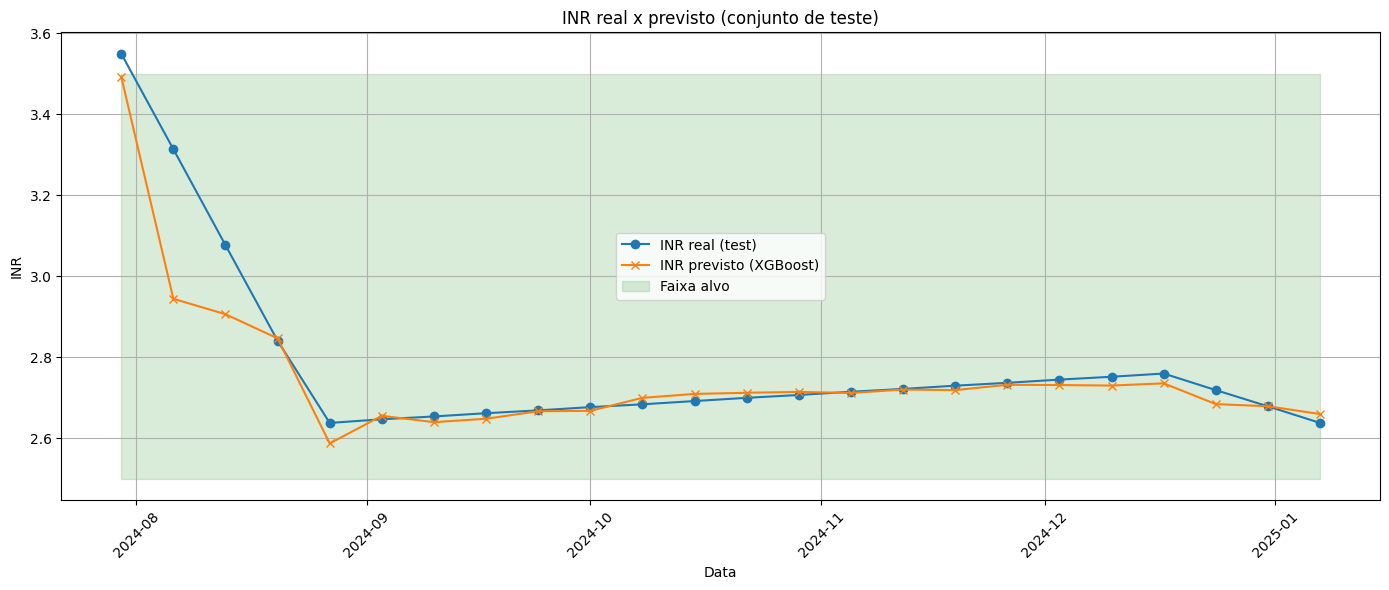

In [17]:
# PLOTS: Atual vs Previsto e Faixa Alvo
plt.figure(figsize=(14,6))
plt.plot(dates_test, y_test.values, label='INR real (test)', marker='o')
plt.plot(dates_test, y_pred_test, label='INR previsto (XGBoost)', marker='x')
# banda alvo (usar low/high arrays)
plt.fill_between(dates_test, low_vals, high_vals, color='green', alpha=0.15, label='Faixa alvo')
plt.xlabel("Data")
plt.ylabel("INR")
plt.title("INR real x previsto (conjunto de teste)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

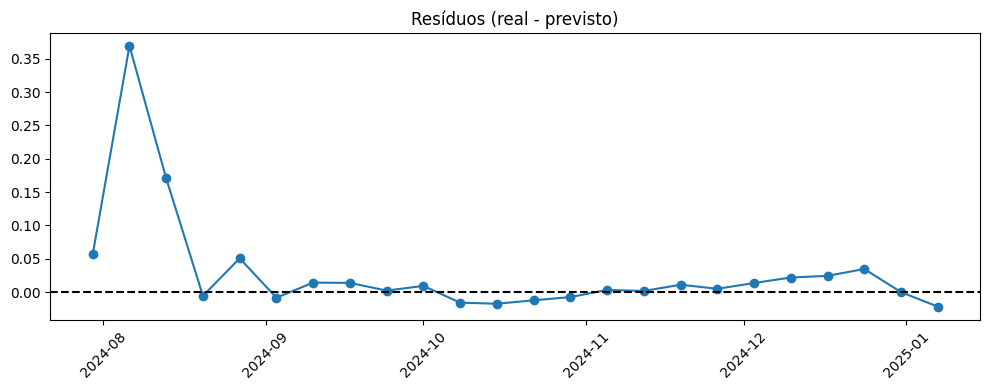

In [18]:
# Residuals
plt.figure(figsize=(10,4))
resid = y_test.values - y_pred_test
plt.plot(dates_test, resid, marker='o')
plt.axhline(0, color='k', linestyle='--')
plt.title("Resíduos (real - previsto)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\pedro\AppData\Local\Temp\ipykernel_18940\1265125338.py:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


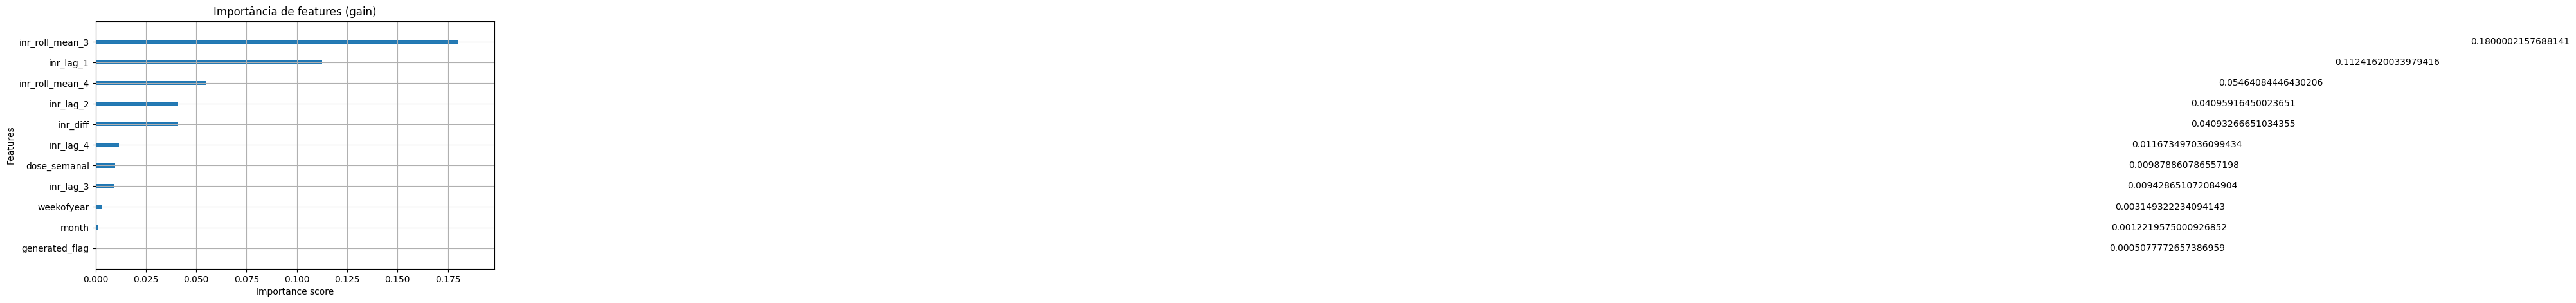

In [19]:
# Feature importance (SHAP seria melhor; aqui importância do modelo)
fig, ax = plt.subplots(figsize=(8,5))
xgb.plot_importance(model, max_num_features=15, ax=ax, importance_type='gain')
plt.title("Importância de features (gain)")
plt.tight_layout()
plt.show()

In [ ]:
# ----------------------------
# DICAS / PRÓXIMOS PASSOS
# ----------------------------
# 1) Hyperparameter tuning: use TimeSeriesSplit + GridSearchCV (ou optuna) para mutos parametros.
# 2) Experimente adicionar features: diffs de ordem maior, exponencial smoothing, medidas do histórico de dose, interação dose*lag.
# 3) Teste normalização apenas se usar modelos sensíveis à escala (SVR, NN, regressão linear com regularização).
# 4) Use SHAP para interpretar predições por ponto.
# 5) Se quiser previsões multi-step (várias semanas à frente), adapte a janela de saída (target deslocado).


## Treinando XGBoost antigo

In [ ]:
DATE_COL = "test_date"               # ### ADAPTAR: nome da coluna de datas
TARGET_COL = "inr"                   # ### ADAPTAR: nome da coluna alvo
TEST_SIZE_RATIO = 0.2                # ### ADAPTAR: proporção final para teste (tempo mais recente)
LAGS = [1, 2, 3, 4]                  # ### ADAPTAR: defina lags (em número de observações)
ROLL_WINDOWS = [2, 4]                # ### ADAPTAR: janelas para médias móveis (em observações)
RANDOM_STATE = 42
MODEL_OUT = "xgb_inr_model.joblib"
EARLY_STOPPING_ROUNDS = 20
NUM_BOOST_ROUND = 1000
VERBOSE = 1

In [10]:
df = data_filtred.copy()

for lag in LAGS:
    df[f"lag_{lag}"] = df[TARGET_COL].shift(lag)

for w in ROLL_WINDOWS:
    df[f"roll_mean_{w}"] = df[TARGET_COL].shift(1).rolling(window=w, min_periods=1).mean()  # média móvel usando registros anteriores

# diferença de tempo (em dias) desde o último teste — pode ajudar o modelo a capturar salto irregular
df["days_since_prev"] = df[DATE_COL].diff().dt.days.fillna(0)

# features de data (úteis para sazonalidade)
df["month"] = df[DATE_COL].dt.month
df["dayofweek"] = df[DATE_COL].dt.dayofweek
df["day"] = df[DATE_COL].dt.day
df["year"] = df[DATE_COL].dt.year

if "low_range" in df.columns and "high_range" in df.columns:
    df["inr_range_width"] = df["high_range"] - df["low_range"]
    df["inr_mid_range"] = (df["high_range"] + df["low_range"]) / 2

In [11]:
df = df.dropna().reset_index(drop=True)

# -----------------------------
# 5) Definir X e y
# -----------------------------
FEATURES = [c for c in df.columns if c not in [TARGET_COL, DATE_COL]]
# se quiser excluir colunas específicas, remova-as aqui
# e.g., if 'some_col' in FEATURES: FEATURES.remove('some_col')

X = df[FEATURES]
y = df[TARGET_COL]

print("Features usadas:", FEATURES)
print("Tamanho do dataset (após dropna):", df.shape)


Features usadas: ['dose_semanal', 'inr_diff', 'low_range', 'high_range', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'roll_mean_2', 'roll_mean_4', 'days_since_prev', 'month', 'dayofweek', 'day', 'year', 'inr_range_width', 'inr_mid_range']
Tamanho do dataset (após dropna): (25, 19)


In [12]:
split_idx = int(len(df) * (1 - TEST_SIZE_RATIO))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Treino: {X_train.shape}, Teste: {X_test.shape}")


Treino: (20, 17), Teste: (5, 17)


In [15]:
model = XGBRegressor(
    n_estimators=NUM_BOOST_ROUND,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    verbosity=0
)

callbacks = [EarlyStopping(rounds=EARLY_STOPPING_ROUNDS, save_best=True)]

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=callbacks,
    verbose=VERBOSE
)

TypeError: XGBModel.fit() got an unexpected keyword argument 'callbacks'

In [17]:
model = XGBRegressor(
    n_estimators=NUM_BOOST_ROUND,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RANDOM_STATE,
    objective="reg:squarederror",
    verbosity=0,
    eval_metric="rmse"   # <-- mover para aqui
)

model.fit(    # early_stopping_rounds=EARLY_STOPPING_ROUNDS,
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=VERBOSE
)

[0]	validation_0-rmse:0.37906	validation_1-rmse:0.41942
[1]	validation_0-rmse:0.36493	validation_1-rmse:0.40904
[2]	validation_0-rmse:0.35567	validation_1-rmse:0.40047
[3]	validation_0-rmse:0.34356	validation_1-rmse:0.39229
[4]	validation_0-rmse:0.33123	validation_1-rmse:0.38347
[5]	validation_0-rmse:0.32244	validation_1-rmse:0.38539
[6]	validation_0-rmse:0.31340	validation_1-rmse:0.38840
[7]	validation_0-rmse:0.30380	validation_1-rmse:0.38663
[8]	validation_0-rmse:0.29805	validation_1-rmse:0.38883
[9]	validation_0-rmse:0.28983	validation_1-rmse:0.39068
[10]	validation_0-rmse:0.28046	validation_1-rmse:0.38467
[11]	validation_0-rmse:0.27328	validation_1-rmse:0.37763
[12]	validation_0-rmse:0.26712	validation_1-rmse:0.37117
[13]	validation_0-rmse:0.26024	validation_1-rmse:0.36369
[14]	validation_0-rmse:0.25186	validation_1-rmse:0.35843
[15]	validation_0-rmse:0.24456	validation_1-rmse:0.36049
[16]	validation_0-rmse:0.23852	validation_1-rmse:0.35396
[17]	validation_0-rmse:0.23166	validation

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'rmse'


In [19]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_pred_train)
rmse_train = mean_squared_error(y_train, y_pred_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = mean_squared_error(y_test, y_pred_test)

print(f"TRAIN MAE: {mae_train:.4f}, RMSE: {rmse_train:.4f}")
print(f" TEST MAE: {mae_test:.4f}, RMSE: {rmse_test:.4f}")


TRAIN MAE: 0.0004, RMSE: 0.0000
 TEST MAE: 0.2420, RMSE: 0.1031


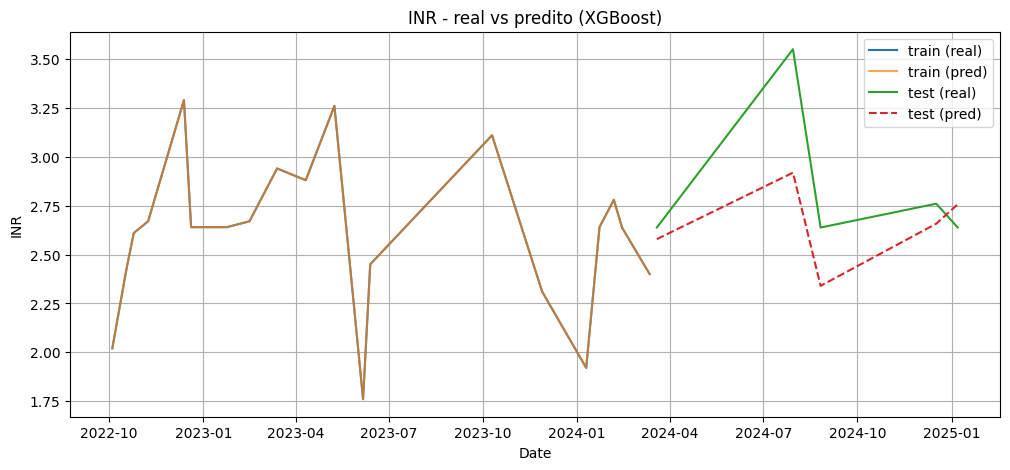

In [21]:
plt.figure(figsize=(12,5))
plt.plot(df[DATE_COL].iloc[:split_idx], y_train, label="train (real)")
plt.plot(df[DATE_COL].iloc[:split_idx], y_pred_train, label="train (pred)", alpha=0.7)
plt.plot(df[DATE_COL].iloc[split_idx:], y_test, label="test (real)")
plt.plot(df[DATE_COL].iloc[split_idx:], y_pred_test, label="test (pred)", linestyle="--")
plt.legend()
plt.title("INR - real vs predito (XGBoost)")
plt.xlabel("Date")
plt.ylabel("INR")
plt.grid(True)
plt.show()

In [24]:
importance = model.feature_importances_
feat_imp = pd.DataFrame({"feature": FEATURES, "importance": importance}).sort_values("importance", ascending=False)
print("\nFeature importance:")
print(feat_imp.head(20))


Feature importance:
            feature  importance
13              day    0.202391
10  days_since_prev    0.201920
1          inr_diff    0.200359
5             lag_2    0.104744
4             lag_1    0.082666
6             lag_3    0.046020
8       roll_mean_2    0.044239
7             lag_4    0.029018
9       roll_mean_4    0.028070
11            month    0.026466
14             year    0.021254
0      dose_semanal    0.012854
3        high_range    0.000000
2         low_range    0.000000
12        dayofweek    0.000000
15  inr_range_width    0.000000
16    inr_mid_range    0.000000


## RandomForest

In [ ]:
RANDOM_STATE = 32

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
X_train_np = np.array(X_train)
y_train_np = np.array(y_train)

param_grid_rf = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [7, 12, 20, None],
    'max_features': ['sqrt', 'log2', None]
} # 4 * 4 * 3 = 48 combinações

cv_folds = 5
skf_rf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

rf_estimator = RandomForestClassifier(random_state=RANDOM_STATE)

grid_search_rf = GridSearchCV(
    estimator=rf_estimator,
    param_grid=param_grid_rf,
    cv=skf_rf,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

print("\n" + "="*70)
print(f"Iniciando Grid Search para Random Forest ({len(param_grid_rf['n_estimators']) * len(param_grid_rf['max_depth']) * len(param_grid_rf['max_features'])} combinações x {cv_folds} Folds)...")
start_time = time.time()

grid_search_rf.fit(X_train_np, y_train_np)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

In [ ]:
best_rf_score = grid_search_rf.best_score_ # Acurácia média da validação cruzada
best_rf_params = grid_search_rf.best_params_
best_rf_model = grid_search_rf.best_estimator_ # Modelo melhor otimizado

print("\n" + "="*70)
print("MELHOR MODELO RANDOM FOREST OTIMIZADO")
print(f"Média Acurácia de Validação ({cv_folds} Folds): {best_rf_score:.4f}")
print("Melhores Parâmetros Encontrados:")
print(f"  - n_estimators: {best_rf_params['n_estimators']}")
print(f"  - max_depth: {best_rf_params['max_depth']}")
print(f"  - max_features: {best_rf_params['max_features']}")
print("="*70)

In [ ]:
y_pred_train = best_rf_model.predict(X_train)
y_pred_test = best_rf_model.predict(X_test)

print("\nDesempenho do Random Forest Final")
print(f"Ein (Erro treino): {1 - accuracy_score(y_train, y_pred_train):.4f}")
print(f"Eout (Erro teste): {1 - accuracy_score(y_test, y_pred_test):.4f}")
print("\nRelatório de classificação (Teste):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Matriz de Confusão - Random Forest Final")
plt.show()